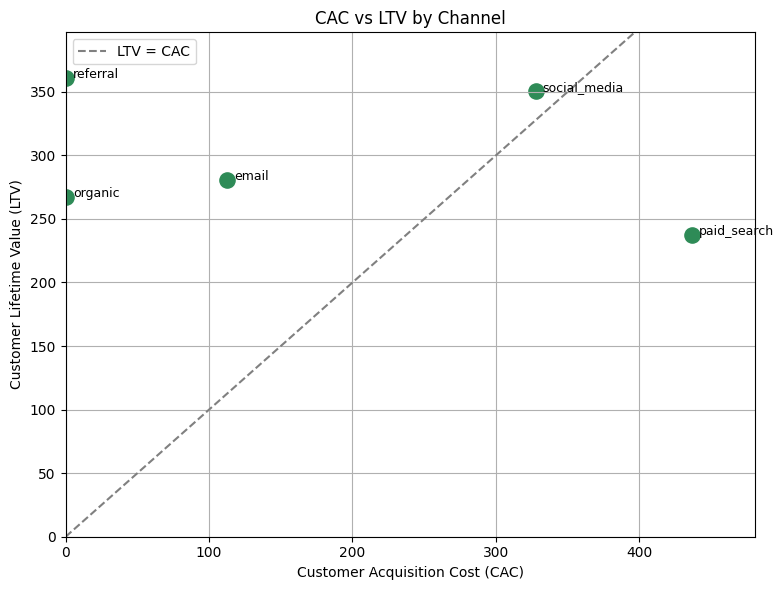

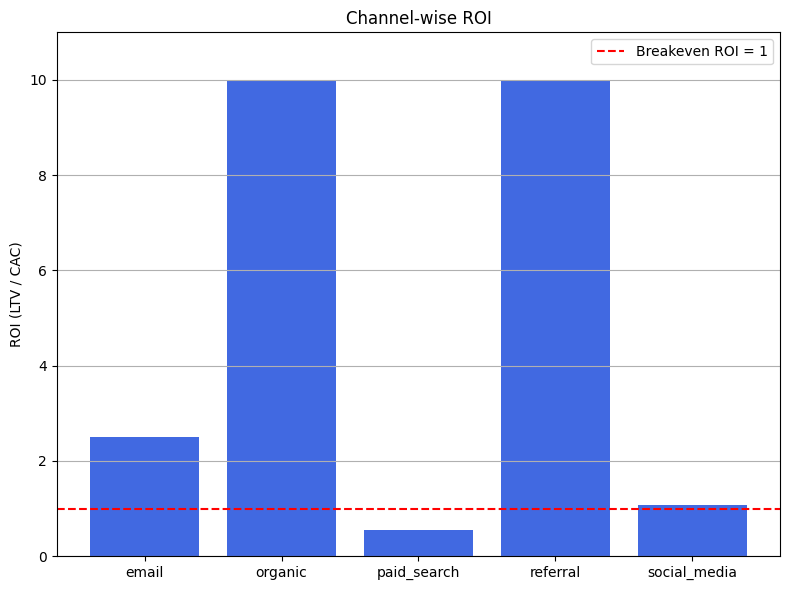

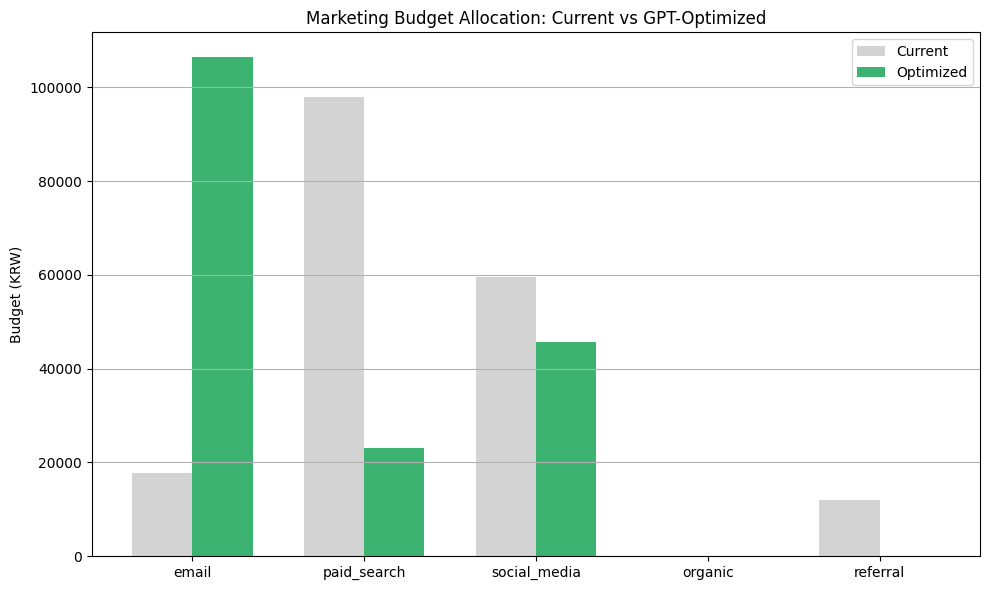

,channel,current_spend,optimal_spend,spend_change
0,email,17763.268813,106391.254276,88627.985462
3,organic,0.000000,0.000000,0.000000
4,referral,11867.432377,0.000000,-11867.432377
2,social_media,59628.676756,45684.280662,-13944.396093
1,paid_search,97849.029394,23165.440025,-74683.589369


In [38]:
# ✅ 문제 1: CAC, LTV, ROI 분석 + 시각화 + GPT 전략 기반 예산 재배분까지 포함된 완성 코드

import pandas as pd
import matplotlib.pyplot as plt

# 1. 데이터 로드
marketing_df = pd.read_csv("marketing_performance.csv")
transactions_df = pd.read_csv("customer_transactions.csv")
satisfaction_df = pd.read_csv("customer_satisfaction.csv")

# 2. 날짜 변환
marketing_df["month"] = pd.to_datetime(marketing_df["month"])
transactions_df["registration_date"] = pd.to_datetime(transactions_df["registration_date"])
transactions_df["transaction_date"] = pd.to_datetime(transactions_df["transaction_date"])

# 3. 2024년 CAC 계산
marketing_2024 = marketing_df[marketing_df["month"].dt.year == 2024]
cac_data = marketing_2024.groupby("channel").agg({
    "marketing_spend": "sum",
    "new_customers": "sum"
}).reset_index()
cac_data["CAC"] = cac_data.apply(
    lambda row: 0 if row["channel"] in ["organic", "referral"] else row["marketing_spend"] / row["new_customers"],
    axis=1
)

# 4. 고객별 LTV 계산
ltv_df = transactions_df.groupby("customer_id").agg({
    "order_value": "sum",
    "transaction_date": ["min", "max", "count"]
})
ltv_df.columns = ["total_spent", "first_tx", "last_tx", "tx_count"]
ltv_df = ltv_df.reset_index()
ltv_df["months_active"] = ((ltv_df["last_tx"] - ltv_df["first_tx"]) / pd.Timedelta(days=30)).round().astype(int).clip(lower=1)
ltv_df["monthly_avg_spent"] = ltv_df["total_spent"] / ltv_df["months_active"]
ltv_df["LTV"] = ltv_df["total_spent"]

# 5. 채널 병합 및 2024년 첫 거래 고객 필터링
channels = transactions_df.drop_duplicates("customer_id")[["customer_id", "acquisition_channel", "registration_date"]]
channels = channels.rename(columns={"acquisition_channel": "channel"})
ltv_df = pd.merge(ltv_df, channels, on="customer_id", how="left")
ltv_df["first_tx_year"] = ltv_df["first_tx"].dt.year
ltv_2024 = ltv_df[ltv_df["first_tx_year"] == 2024]

# 6. 채널별 평균 LTV, 월평균 구매액
ltv_by_channel = ltv_2024.groupby("channel").agg({
    "LTV": "mean",
    "monthly_avg_spent": "mean"
}).reset_index()

# 7. ROI 및 Payback 계산
roi_df = pd.merge(cac_data, ltv_by_channel, on="channel", how="inner")
roi_df["ROI"] = roi_df.apply(lambda row: float("inf") if row["CAC"] == 0 else row["LTV"] / row["CAC"], axis=1)
roi_df["payback_period_months"] = roi_df.apply(
    lambda row: float("inf") if row["CAC"] == 0 else row["CAC"] / row["monthly_avg_spent"],
    axis=1
)

# 안전한 축 최대값
cac_max = roi_df["CAC"].replace([float("inf"), -float("inf")], pd.NA).dropna().max() or 1
ltv_max = roi_df["LTV"].replace([float("inf"), -float("inf")], pd.NA).dropna().max() or 1

# 8-1. CAC vs LTV 산점도
plt.figure(figsize=(8, 6))
plt.scatter(roi_df["CAC"], roi_df["LTV"], s=120, color="seagreen")
for _, row in roi_df.iterrows():
    if pd.notna(row["CAC"]) and pd.notna(row["LTV"]):
        plt.text(row["CAC"] + 5, row["LTV"], row["channel"], fontsize=9)
plt.plot([0, cac_max], [0, cac_max], linestyle="--", color="gray", label="LTV = CAC")
plt.xlim(0, cac_max * 1.1)
plt.ylim(0, ltv_max * 1.1)
plt.xlabel("Customer Acquisition Cost (CAC)")
plt.ylabel("Customer Lifetime Value (LTV)")
plt.title("CAC vs LTV by Channel")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 8-2. ROI 막대 차트
plt.figure(figsize=(8, 6))
roi_display = roi_df.copy()
roi_display["ROI_display"] = roi_display["ROI"].replace([float("inf"), float("nan")], 10)
roi_max = roi_display["ROI_display"].dropna().max() or 2
plt.bar(roi_display["channel"], roi_display["ROI_display"], color="royalblue")
plt.axhline(1, color='red', linestyle='--', label="Breakeven ROI = 1")
plt.ylim(0, roi_max + 1)
plt.ylabel("ROI (LTV / CAC)")
plt.title("Channel-wise ROI")
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# 9. ROI 기반 예산 재배분 전략
paid_channels = roi_df[roi_df["CAC"] > 0].copy()
paid_channels["roi_weight"] = paid_channels["ROI"].clip(lower=0)
total_paid_budget = paid_channels["marketing_spend"].sum()
paid_channels["optimal_spend"] = (paid_channels["roi_weight"] / paid_channels["roi_weight"].sum()) * total_paid_budget

free_channels = roi_df[roi_df["CAC"] == 0].copy()
free_channels["optimal_spend"] = 0

gpt_budget_df = pd.concat([paid_channels, free_channels], ignore_index=True)
gpt_budget_df["current_spend"] = gpt_budget_df["marketing_spend"]
gpt_budget_df["spend_change"] = gpt_budget_df["optimal_spend"] - gpt_budget_df["current_spend"]

# 9-1. 예산 재배분 시각화
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = range(len(gpt_budget_df))
plt.bar(index, gpt_budget_df["current_spend"], bar_width, label="Current", color="lightgray")
plt.bar([i + bar_width for i in index], gpt_budget_df["optimal_spend"], bar_width, label="Optimized", color="mediumseagreen")
plt.xticks([i + bar_width / 2 for i in index], gpt_budget_df["channel"])
plt.ylabel("Budget (KRW)")
plt.title("Marketing Budget Allocation: Current vs GPT-Optimized")
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# 9-2. 예산 변화 요약 테이블
gpt_budget_df[["channel", "current_spend", "optimal_spend", "spend_change"]].sort_values("spend_change", ascending=False)


In [36]:
print("🧪 2024년 CAC 계산용 채널 목록:")
print(cac_data["channel"].unique())

print("\n🧪 2024년 신규 고객 수 (LTV 대상):", len(ltv_2024))
print(ltv_2024[["customer_id", "channel", "LTV"]].head())

print("\n🧪 LTV 계산 대상 고객 수:", len(ltv_df))
print("🧪 LTV 채널 목록:", ltv_df["channel"].dropna().unique())


🧪 2024년 CAC 계산용 채널 목록:
['email' 'organic' 'paid_search' 'referral' 'social_media']

🧪 2024년 신규 고객 수 (LTV 대상): 0
Empty DataFrame
Columns: [customer_id, channel, LTV]
Index: []

🧪 LTV 계산 대상 고객 수: 1000
🧪 LTV 채널 목록: ['email' 'paid_search' 'social_media' 'organic' 'referral']


In [21]:
marketing_df

,month,channel,marketing_spend,new_customers,website_visits,conversions
0,2023-01-01,organic,0.000000,28,511,28
1,2023-01-01,paid_search,11986.882840,19,995,19
2,2023-01-01,social_media,4235.453095,17,1048,17
3,2023-01-01,email,1693.773605,17,1037,17
4,2023-01-01,referral,887.489645,10,958,10
...,...,...,...,...,...,...
115,2024-12-01,organic,0.000000,27,505,27
116,2024-12-01,paid_search,6149.273297,20,999,20
117,2024-12-01,social_media,4668.252208,14,1028,14
118,2024-12-01,email,1496.013316,9,1013,9
